# Implementation of DANN
Reference: https://arxiv.org/pdf/1505.07818.pdf

In [1]:
import torch
import torchvision
import torch.nn as nn

In [2]:
torch.__version__

'1.0.0'

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [4]:
import numpy as np
import datetime
import os, sys

In [5]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [6]:
MODEL_NAME = 'DANN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class FeatureExtractor(nn.Module):
    """
        Feature Extractor
    """
    def __init__(self, in_channel=1, hidden_dims=512):
        super(FeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, hidden_dims, 3, padding=1),
            nn.BatchNorm2d(hidden_dims),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        
    def forward(self, x):
        h = self.conv(x).squeeze() # (N, hidden_dims)
        return h

In [8]:
class Classifier(nn.Module):
    """
        Classifier
    """
    def __init__(self, input_size=512, num_classes=10):
        super(Classifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )
        
    def forward(self, h):
        c = self.layer(h)
        return c

In [9]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=512, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, h):
        y = self.layer(h)
        return y

In [10]:
F = FeatureExtractor().to(DEVICE)
C = Classifier().to(DEVICE)
D = Discriminator().to(DEVICE)

In [11]:
transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],
                         std=[0.5])
])

In [12]:
mnist_train = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='../data/', train=False, transform=transform, download=True)

In [13]:
svhn_train = datasets.SVHN(root='../data/', split='train', transform=transform, download=True)
svhn_test = datasets.SVHN(root='../data/', split='test', transform=transform, download=True)

Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/test_32x32.mat


In [14]:
batch_size = 64

In [15]:
svhn_train.data.shape

(73257, 3, 32, 32)

In [16]:
svhn_loader = DataLoader(dataset=svhn_train, batch_size=batch_size, shuffle=True, drop_last=True)
mnist_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
eval_loader = DataLoader(dataset=svhn_test, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=False, drop_last=False)

In [17]:
bce = nn.BCELoss()
xe = nn.CrossEntropyLoss()

In [18]:
F_opt = torch.optim.Adam(F.parameters())
C_opt = torch.optim.Adam(C.parameters())
D_opt = torch.optim.Adam(D.parameters())

In [19]:
max_epoch = 50
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_batches = len(mnist_train)//batch_size
# lamda = 0.01

In [20]:
D_src = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_tgt = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake
D_labels = torch.cat([D_src, D_tgt], dim=0)

### Training Code



In [21]:
def get_lambda(epoch, max_epoch):
    p = epoch / max_epoch
    return 2. / (1+np.exp(-10.*p)) - 1.

In [22]:
mnist_set = iter(mnist_loader)

def sample_mnist(step, n_batches):
    global mnist_set
    if step % n_batches == 0:
        mnist_set = iter(mnist_loader)
    return mnist_set.next()

In [23]:
ll_c, ll_d = [], []
acc_lst = []

In [24]:
for epoch in range(1, max_epoch+1):
    for idx, (src_images, labels) in enumerate(svhn_loader):
        tgt_images, _ = sample_mnist(step, n_batches)
        # Training Discriminator
        src, labels, tgt = src_images.to(DEVICE), labels.to(DEVICE), tgt_images.to(DEVICE)
        
        x = torch.cat([src, tgt], dim=0)
        h = F(x)
        y = D(h.detach())
        
        Ld = bce(y, D_labels)
        D.zero_grad()
        Ld.backward()
        D_opt.step()
        
        
        c = C(h[:batch_size])
        y = D(h)
        Lc = xe(c, labels)
        Ld = bce(y, D_labels)
        lamda = 0.1*get_lambda(epoch, max_epoch)
        Ltot = Lc -lamda*Ld
        
        
        F.zero_grad()
        C.zero_grad()
        D.zero_grad()
        
        Ltot.backward()
        
        C_opt.step()
        F_opt.step()
        
        if step % 100 == 0:
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}, D Loss: {:.4f}, C Loss: {:.4f}, lambda: {:.4f} ---- {}'.format(epoch, max_epoch, step, Ld.item(), Lc.item(), lamda, dt))
            ll_c.append(Lc)
            ll_d.append(Ld)
        
        if step % 500 == 0:
            F.eval()
            C.eval()
            with torch.no_grad():
                corrects = torch.zeros(1).to(DEVICE)
                for idx, (src, labels) in enumerate(eval_loader):
                    src, labels = src.to(DEVICE), labels.to(DEVICE)
                    c = C(F(src))
                    _, preds = torch.max(c, 1)
                    corrects += (preds == labels).sum()
                acc = corrects.item() / len(eval_loader.dataset)
                print('***** Eval Result: {:.4f}, Step: {}'.format(acc, step))
                
                corrects = torch.zeros(1).to(DEVICE)
                for idx, (tgt, labels) in enumerate(test_loader):
                    tgt, labels = tgt.to(DEVICE), labels.to(DEVICE)
                    c = C(F(tgt))
                    _, preds = torch.max(c, 1)
                    corrects += (preds == labels).sum()
                acc = corrects.item() / len(test_loader.dataset)
                print('***** Test Result: {:.4f}, Step: {}'.format(acc, step))
                acc_lst.append(acc)
                
            F.train()
            C.train()
        step += 1

Epoch: 1/50, Step: 0, D Loss: 0.6522, C Loss: 2.3132, lambda: 0.0100 ---- 05:01:31
***** Eval Result: 0.0776, Step: 0
***** Test Result: 0.1028, Step: 0
Epoch: 1/50, Step: 100, D Loss: 0.0076, C Loss: 2.2316, lambda: 0.0100 ---- 05:01:53
Epoch: 1/50, Step: 200, D Loss: 0.5378, C Loss: 2.2189, lambda: 0.0100 ---- 05:02:05
Epoch: 1/50, Step: 300, D Loss: 0.0191, C Loss: 2.0384, lambda: 0.0100 ---- 05:02:16
Epoch: 1/50, Step: 400, D Loss: 0.0017, C Loss: 2.0873, lambda: 0.0100 ---- 05:02:28
Epoch: 1/50, Step: 500, D Loss: 0.0008, C Loss: 1.9332, lambda: 0.0100 ---- 05:02:39
***** Eval Result: 0.2978, Step: 500
***** Test Result: 0.1208, Step: 500
Epoch: 1/50, Step: 600, D Loss: 0.0010, C Loss: 2.2156, lambda: 0.0100 ---- 05:03:03
Epoch: 1/50, Step: 700, D Loss: 0.0036, C Loss: 1.9834, lambda: 0.0100 ---- 05:03:14
Epoch: 1/50, Step: 800, D Loss: 0.0011, C Loss: 1.8168, lambda: 0.0100 ---- 05:03:26
Epoch: 1/50, Step: 900, D Loss: 0.0081, C Loss: 1.7745, lambda: 0.0100 ---- 05:03:38
Epoch: 1

***** Test Result: 0.6501, Step: 8000
Epoch: 8/50, Step: 8100, D Loss: 0.6352, C Loss: 0.3296, lambda: 0.0664 ---- 05:20:40
Epoch: 8/50, Step: 8200, D Loss: 0.5349, C Loss: 0.3655, lambda: 0.0664 ---- 05:20:52
Epoch: 8/50, Step: 8300, D Loss: 0.5734, C Loss: 0.3377, lambda: 0.0664 ---- 05:21:04
Epoch: 8/50, Step: 8400, D Loss: 0.6532, C Loss: 0.2262, lambda: 0.0664 ---- 05:21:16
Epoch: 8/50, Step: 8500, D Loss: 0.6611, C Loss: 0.4979, lambda: 0.0664 ---- 05:21:27
***** Eval Result: 0.9125, Step: 8500
***** Test Result: 0.5969, Step: 8500
Epoch: 8/50, Step: 8600, D Loss: 0.6962, C Loss: 0.2419, lambda: 0.0664 ---- 05:21:51
Epoch: 8/50, Step: 8700, D Loss: 0.7327, C Loss: 0.1832, lambda: 0.0664 ---- 05:22:03
Epoch: 8/50, Step: 8800, D Loss: 0.7048, C Loss: 0.1743, lambda: 0.0664 ---- 05:22:14
Epoch: 8/50, Step: 8900, D Loss: 0.6131, C Loss: 0.3559, lambda: 0.0664 ---- 05:22:26
Epoch: 8/50, Step: 9000, D Loss: 0.5771, C Loss: 0.3586, lambda: 0.0664 ---- 05:22:38
***** Eval Result: 0.9025,

***** Eval Result: 0.9231, Step: 16000
***** Test Result: 0.6458, Step: 16000
Epoch: 15/50, Step: 16100, D Loss: 0.7629, C Loss: 0.2981, lambda: 0.0905 ---- 05:39:32
Epoch: 15/50, Step: 16200, D Loss: 0.6047, C Loss: 0.3546, lambda: 0.0905 ---- 05:39:44
Epoch: 15/50, Step: 16300, D Loss: 0.6628, C Loss: 0.1468, lambda: 0.0905 ---- 05:39:56
Epoch: 15/50, Step: 16400, D Loss: 0.6806, C Loss: 0.1953, lambda: 0.0905 ---- 05:40:08
Epoch: 15/50, Step: 16500, D Loss: 0.6021, C Loss: 0.1075, lambda: 0.0905 ---- 05:40:20
***** Eval Result: 0.9227, Step: 16500
***** Test Result: 0.6705, Step: 16500
Epoch: 15/50, Step: 16600, D Loss: 0.6942, C Loss: 0.3199, lambda: 0.0905 ---- 05:40:43
Epoch: 15/50, Step: 16700, D Loss: 0.7544, C Loss: 0.1337, lambda: 0.0905 ---- 05:40:55
Epoch: 15/50, Step: 16800, D Loss: 0.5320, C Loss: 0.4549, lambda: 0.0905 ---- 05:41:07
Epoch: 15/50, Step: 16900, D Loss: 0.7177, C Loss: 0.2345, lambda: 0.0905 ---- 05:41:19
Epoch: 15/50, Step: 17000, D Loss: 0.6597, C Loss: 0

KeyboardInterrupt: 

## Visualize Sample

In [26]:
import matplotlib.pyplot as plt

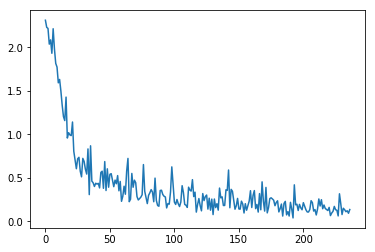

In [27]:
# XE loss
plt.plot(range(len(ll_c)), ll_c)

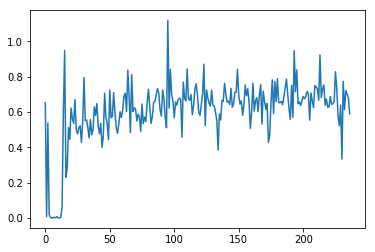

In [28]:
# Discriminator loss
plt.plot(range(len(ll_d)), ll_d)

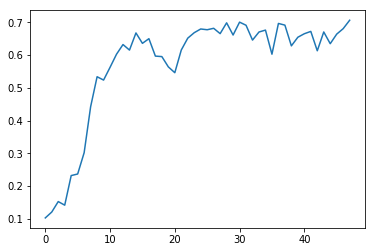

In [29]:
# Accuracy
plt.plot(range(len(acc_lst)), acc_lst)

In [30]:
max(acc_lst)

0.7064